In [3]:
import torch
from torchtext.datasets import IMDB
from torchtext.data import to_map_style_dataset
import pandas as pd
import numpy as np

In [4]:
# Download the dataset. Merge train and test.
train_iter, test_iter = IMDB()
train_iter, test_iter = iter(train_iter), iter(test_iter)
train_list, test_list = list(train_iter), list(test_iter)

In [7]:
df = pd.DataFrame(train_list+test_list, columns=['labels', 'texts'])
df.head()

,labels,texts
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


In [86]:
# Save full dataset
df.to_csv(r'IMDB.csv', index=False)

In [8]:
# Checking the memory consuption
import sys

# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df', 71532560),
 ('test_list', 219064),
 ('train_list', 219064),
 ('IMDB', 136),
 ('to_map_style_dataset', 136),
 ('test_iter', 112),
 ('train_iter', 112),
 ('np', 72),
 ('pd', 72)]

In [7]:
del test_list, train_list

In [8]:
# Check is everything fine
imdb_dataframe = pd.read_csv(r'IMDB.csv')
imdb_dataframe.head()

,labels,texts
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


In [12]:
import sys
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('imdb_dataframe', 71532560),
 ('IMDB', 136),
 ('to_map_style_dataset', 136),
 ('test_iter', 112),
 ('train_iter', 112),
 ('np', 72),
 ('pd', 72)]

In [13]:
imdb_dataframe['labels'] = imdb_dataframe['labels'].map({'neg': 0, 'pos': 1})
imdb_dataframe.sample(3)

,labels,texts
4415,0,A less-than-subtle poke at the beliefs and tea...
19571,1,I saw the movie before I read the Michelle Mag...
32477,0,"Hello all--for what it's worth, I'm in a docto..."


In [14]:
# View the class distribution
imdb_dataframe['labels'].iloc[25000:].value_counts()

0    12500
1    12500
Name: labels, dtype: int64

In [16]:
# Create map-style dataset
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, target_transform=None):
        self.csv_data = pd.read_csv(csv_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        text = self.csv_data.iloc[idx, 1]
        label = self.csv_data.iloc[idx, 0]
        if self.transform:
            text = torch.tensor(self.transform(text), dtype=torch.int64)
        if self.target_transform:
            label = self.target_transform(label)
        return text, label

In [15]:
# Tokenize reviews
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [17]:
imdb_dataframe['tokenized'] = imdb_dataframe['texts'].map(tokenizer)

In [18]:
imdb_dataframe.sample(5)

,labels,texts,tokenized
20047,1,"I swear when I first saw this movie,I cried my...","[i, swear, when, i, first, saw, this, movie, ,..."
11059,0,"A very ordinary made-for-tv product, ""Tyson"" a...","[a, very, ordinary, made-for-tv, product, ,, t..."
37295,0,As I sit back after watching Wong Kar-wai's 19...,"[as, i, sit, back, after, watching, wong, kar-..."
10627,0,Nothing to say but Wow! Has anyone actually ha...,"[nothing, to, say, but, wow, !, has, anyone, a..."
48953,1,This movie was great don't understand the disr...,"[this, movie, was, great, don, ', t, understan..."


In [19]:
imdb_dataframe['texts_len'] = imdb_dataframe['tokenized'].map(lambda x: len(x))
imdb_dataframe.sample(5)

,labels,texts,tokenized,texts_len
19632,1,Time paradoxes are the devil's snare for under...,"[time, paradoxes, are, the, devil, ', s, snare...",463
15420,1,I saw this movie at an advance screening and f...,"[i, saw, this, movie, at, an, advance, screeni...",179
20531,1,I first saw this film when i was around 6 or 7...,"[i, first, saw, this, film, when, i, was, arou...",408
36496,0,"The key scene in Rodrigo Garcia's ""Nine Lives""...","[the, key, scene, in, rodrigo, garcia, ', s, n...",485
44064,1,"Back in the day, I was one of the RN's in the ...","[back, in, the, day, ,, i, was, one, of, the, ...",272


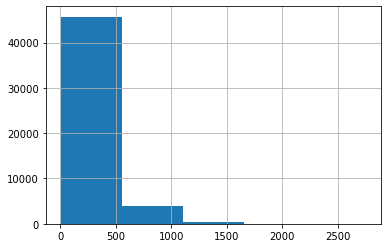

In [20]:
# View text lenghts distribution
imdb_dataframe['texts_len'].hist(bins=5);

In [21]:
np.histogram(imdb_dataframe['texts_len'], bins=5)

(array([45713,  3982,   293,     8,     4]),
 array([   8. ,  556.8, 1105.6, 1654.4, 2203.2, 2752. ]))

In [22]:
# Split dataframe and check class distribution
imdb_dataframe_train = imdb_dataframe.sample(frac=0.7)
imdb_dataframe_train['labels'].value_counts()

0    17501
1    17499
Name: labels, dtype: int64

In [23]:
imdb_dataframe_valid = (imdb_dataframe.drop(imdb_dataframe_train.index)
                                      .sample(frac=0.5))
imdb_dataframe_valid['labels'].value_counts()

1    3753
0    3747
Name: labels, dtype: int64

In [24]:
imdb_dataframe_test = imdb_dataframe.drop(index=np.concatenate([imdb_dataframe_train.index.values 
                                          ,imdb_dataframe_valid.index.values]))
imdb_dataframe_test['labels'].value_counts()

0    3752
1    3748
Name: labels, dtype: int64

In [25]:
# Check are there same samples in splitted dataframes
print(
    np.array(
        [idx in imdb_dataframe_valid.index.values for idx in imdb_dataframe_test.index.values]
    ).sum()
)
print(imdb_dataframe_test.index.values in imdb_dataframe_test.index.values)

0
True


In [26]:
# Sort reviews by lenght
imdb_dataframe_train.sort_values(by=['texts_len'], ascending=False, inplace=True)
imdb_dataframe_valid.sort_values(by=['texts_len'], ascending=False, inplace=True)
imdb_dataframe_test.sort_values(by=['texts_len'], ascending=False, inplace=True)

In [27]:
print(imdb_dataframe_train['texts_len'].values[:10])
print(imdb_dataframe_valid['texts_len'].values[:10])
print(imdb_dataframe_test['texts_len'].values[:10])

[2752 2623 2467 2072 1901 1701 1665 1614 1599 1549]
[1992 1722 1549 1299 1256 1206 1199 1199 1184 1182]
[2474 2022 1923 1486 1334 1310 1244 1211 1210 1209]


In [28]:
# imdb_dataframe_train.to_csv(r'IMDB_train.csv', columns=['labels', 'texts'], index=False)
# imdb_dataframe_valid.to_csv(r'IMDB_valid.csv', columns=['labels', 'texts'], index=False)
# imdb_dataframe_test.to_csv(r'IMDB_test.csv', columns=['labels', 'texts'], index=False)

In [29]:
train_dataset = CustomDataset(csv_file=r'IMDB_train.csv')
valid_dataset = CustomDataset(csv_file=r'IMDB_valid.csv')
test_dataset = CustomDataset(csv_file=r'IMDB_test.csv')

In [31]:
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(imdb_dataframe_train['tokenized'], specials=['<pad>', '<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [32]:
# Create dataloader from dataset and make batch preprocess
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    batch_text2id_seq = [torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64) for _text, _ in batch]
    batch_label_seq = torch.tensor([_label for _, _label in batch], dtype=torch.float)
    batch_label_seq = batch_label_seq.unsqueeze(1)
    batch_len_seq = [len(seq) for seq in batch_text2id_seq]
    
    batch_padded = pad_sequence(batch_text2id_seq, batch_first=True)
    return batch_padded.to(device), batch_label_seq.to(device), batch_len_seq

dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_batch)

In [33]:
# Check is everything fine
k = 0
for i, j, l in dataloader:
    k+=1
    print(i.shape, j.shape, l)
    if k == 5:
        break

torch.Size([32, 2752]) torch.Size([32, 1]) [2752, 2623, 2474, 2467, 2022, 1992, 1923, 1722, 1701, 1614, 1599, 1549, 1549, 1488, 1486, 1469, 1440, 1428, 1347, 1334, 1317, 1300, 1299, 1284, 1256, 1249, 1247, 1234, 1227, 1226, 1220, 1217]
torch.Size([32, 1213]) torch.Size([32, 1]) [1213, 1212, 1211, 1210, 1210, 1209, 1206, 1206, 1206, 1205, 1203, 1202, 1202, 1199, 1197, 1193, 1190, 1189, 1188, 1187, 1186, 1184, 1184, 1183, 1183, 1182, 1178, 1177, 1175, 1175, 1174, 1173]
torch.Size([32, 1173]) torch.Size([32, 1]) [1173, 1173, 1173, 1172, 1172, 1172, 1172, 1170, 1169, 1169, 1169, 1168, 1167, 1165, 1164, 1164, 1163, 1163, 1163, 1162, 1160, 1160, 1160, 1159, 1158, 1158, 1158, 1158, 1157, 1155, 1155, 1154]
torch.Size([32, 1154]) torch.Size([32, 1]) [1154, 1153, 1153, 1153, 1152, 1152, 1152, 1152, 1151, 1150, 1150, 1149, 1149, 1149, 1149, 1149, 1148, 1147, 1146, 1144, 1144, 1144, 1143, 1143, 1143, 1143, 1143, 1143, 1142, 1142, 1142, 1141]
torch.Size([32, 1141]) torch.Size([32, 1]) [1141, 1140, 

In [34]:
import torch.nn as nn
class RNNBaseline(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 n_layers, 
                 dropout=0,
                 bidirectional=False, 
                 pad_idx=0, 
                 num_classes=1):
        
        super().__init__()
        
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(input_size = embedding_dim,
                           hidden_size = hidden_dim,
                           num_layers = n_layers,
                           bidirectional = bidirectional,
                           dropout = dropout,
                           batch_first=True)
        if dropout:
            self.dropout_l = nn.Dropout(p=dropout)
        else:
            self.dropout_l = None
            
        if bidirectional:
             self.fc = nn.Linear(2*hidden_dim, num_classes)
        else:
             self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
        
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        # unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)  
        
        """
        output = [batch size, sent len padded , hid dim * num directions]
        hidden = [batch size, num layers * num directions, hid dim]
        concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) 
        hidden layers and apply dropout
        """
    
        if self.bidirectional:
            hidden = torch.cat([hidden[-2,:,:], hidden[-1,:,:]], dim=-1)
        else:
            hidden = hidden[-1,:,:]
        if self.dropout_l is not None:
            hidden = self.dropout_l(hidden)
            
        return self.fc(hidden)

In [76]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 100
    start_time = time.time()
    for idx, (text, label, length) in enumerate(dataloader):
        opt.zero_grad()
        predicted_label = model(text, length)
        loss = loss_func(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        opt.step()
        total_acc += ((torch.sigmoid(predicted_label) > 0.5) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f} | lr: {:.0e}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count, scheduler.get_last_lr()[0]))

            total_acc, total_count = 0, 0
            start_time = time.time()
            
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    
    with torch.no_grad():
        for idx, (text, label, length) in enumerate(dataloader):
            predicted_label = model(text, length)
            total_acc += ((torch.sigmoid(predicted_label) > 0.5) == label).sum().item()
            total_count += label.size(0)
        return total_acc/total_count

In [77]:
vocab_size = len(vocab)
emb_dim = 200
hidden_dim = 512
num_classes = 1
n_layers = 2
bidirectional = True
dropout = 0.5
PAD_IDX = vocab['<pad>']

model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)

model = model.to(device)

opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(opt, 1.0, gamma=0.1)

BATCH_SIZE = 32
max_epochs = 10

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=collate_batch)

In [78]:
total_accu = None

for epoch in range(1, max_epochs + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
   
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   100/ 1094 batches | accuracy    0.580 | lr: 1e-03
| epoch   1 |   200/ 1094 batches | accuracy    0.586 | lr: 1e-03
| epoch   1 |   300/ 1094 batches | accuracy    0.552 | lr: 1e-03
| epoch   1 |   400/ 1094 batches | accuracy    0.573 | lr: 1e-03
| epoch   1 |   500/ 1094 batches | accuracy    0.612 | lr: 1e-03
| epoch   1 |   600/ 1094 batches | accuracy    0.583 | lr: 1e-03
| epoch   1 |   700/ 1094 batches | accuracy    0.654 | lr: 1e-03
| epoch   1 |   800/ 1094 batches | accuracy    0.675 | lr: 1e-03
| epoch   1 |   900/ 1094 batches | accuracy    0.713 | lr: 1e-03
| epoch   1 |  1000/ 1094 batches | accuracy    0.777 | lr: 1e-03
-----------------------------------------------------------
| end of epoch   1 | time: 132.59s | valid accuracy    0.783 
-----------------------------------------------------------
| epoch   2 |   100/ 1094 batches | accuracy    0.793 | lr: 1e-03
| epoch   2 |   200/ 1094 batches | accuracy    0.816 | lr: 1e-03
| epoch   2 |   300/ 1094 

In [79]:
evaluate(test_dataloader)

0.9082666666666667

In [80]:
torch.save(model.state_dict(), r'LSTM_BI_2L.pt')

In [81]:
model_saved = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)
model_saved.load_state_dict(torch.load(r'LSTM_BI_2L.pt'))

<All keys matched successfully>

In [83]:
model_saved.to(device)
model_saved.eval()
total_acc, total_count = 0, 0

with torch.no_grad():
    # pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False, position=0)
    # pbar.set_description(f"Epoch {epoch}(valid)")
    for idx, (text, label, length) in enumerate(test_dataloader):
        predicted_label = model_saved(text, length)
        total_acc += ((torch.sigmoid(predicted_label) > 0.5) == label).sum().item()
        total_count += label.size(0)
print(total_acc/total_count)

0.9082666666666667


In [146]:
def ev(sen):
    model.eval()
    with torch.no_grad():
        tokenized = tokenizer(sen)
        inp = torch.tensor(vocab(tokenized)).unsqueeze(0).to(device)
        length = torch.tensor(inp.size(1)).unsqueeze(0).to('cpu')
        pred = torch.sigmoid(model(inp, length))
    return pred.item()
ev('It was a fantastic performance !')

0.9988327622413635

In [149]:
# Evaluate model on new phrases
sentences = ['Best film ever', 
             'Such a great show!', 
             'It was a horrible movie', 
             'I\'ve never watched something as bad', 
             'It is a disgusting movie!', 
             'So-so. I\'d watched something better you know']
for sen in sentences:
    print(ev(sen))

0.9999808073043823
0.9999887943267822
5.189242074266076e-06
0.00045184246846474707
7.519365681218915e-06
1.030789604783422e-07
